In [ ]:
import pandas as pd
from datetime import datetime, date, time, timedelta
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from prophet import Prophet
from functions_anton.functions_models import step_modification_to_forecast 
#from functions_anton.functions_models import plot_forecast 

# Adjusted plotting function

In [ ]:
def plot_forecast(df_train, df_test, station_uuid = None, df_train_prediction=None, df_test_prediction=None, train_dates=None, test_dates=None, train_dates_plot=None, test_dates_plot=None):
    plt.figure(figsize=(15, 6))
    
    train_mask = (df_train['date'] >= train_dates[0]) & (df_train['date'] <= train_dates[1]) if train_dates else slice(None)
    test_mask = (df_test['date'] >= test_dates[0]) & (df_test['date'] <= test_dates[1]) if test_dates else slice(None)


    if station_uuid is not None:
        df_train = df_train[df_train['station_uuid'] == station_uuid]
        df_test = df_test[df_test['station_uuid'] == station_uuid]

    if df_train_prediction is not None:
        df_train_prediction = df_train_prediction[(df_train_prediction['date'] >= train_dates[0]) & (df_train_prediction['date'] <= train_dates[1])]
        #plt.plot(df_train_prediction['date'], df_train_prediction['e5'], label='Train Prediction', color='green', linestyle='--', linewidth=2, drawstyle='steps-post')

    if df_test_prediction is not None:
        df_test_prediction = df_test_prediction[(df_test_prediction['date'] >= test_dates[0]) & (df_test_prediction['date'] <= test_dates[1])]
        plt.plot(df_test_prediction['date'], df_test_prediction['e5'], label='Test Prediction', color='red', linestyle='--', linewidth=2, drawstyle='steps-post')

        # --- Error Calculation and Display ---
        df_merged = df_test.merge(df_test_prediction, on='date', suffixes=('_actual', '_pred'))
        df_merged = df_merged.sort_values('date').reset_index(drop=True)

        mae_dict = {}
        rmse_dict = {}
        r2_dict = {}

        for i, days in enumerate([1, 3, 7]):
            time_cutoff = df_merged['datetime'].min() + timedelta(days=days)
            df_subset = df_merged[df_merged['datetime'] < time_cutoff]

            if not df_subset.empty:
                mae = mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred'])
                rmse = np.sqrt(mean_squared_error(df_subset['e5_actual'], df_subset['e5_pred']))
                r2 = r2_score(df_subset['e5_actual'], df_subset['e5_pred'])
                mae_dict[days] = mae
                rmse_dict[days] = rmse
                r2_dict[days] = r2

                print(f"{days}-Day MAE in cent: {mae *100:.4f}")
                print(f"{days}-Day RMSE in cent: {rmse *100:.4f}")
                print(f"{days}-Day r2-score: {r2:.4f}")
                #plt.text(0.01, 0.95 - 0.05 * i, f'{days}-day MAE in cent: {mae*100:.4f}', 
                         #transform=plt.gca().transAxes, fontsize=12, 
                         #bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7))
    
    plt.plot(df_train.loc[train_mask, 'date'], df_train.loc[train_mask, 'e5'], label='Train Actual', color='blue', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.plot(df_test.loc[test_mask, 'date'], df_test.loc[test_mask, 'e5'], label='Test Actual', color='orange', linewidth=2, drawstyle='steps-post', alpha=0.7)

    plt.legend(fontsize=12, title_fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('E5 Price: Actual vs Prediction', fontsize=16)
    plt.xlabel('date', fontsize=14)
    plt.ylabel('E5 price', fontsize=14)
    plt.tight_layout(pad=2)
    plt.gca().set_facecolor('#f7f7fa')
    plt.gcf().patch.set_facecolor('#eaeaf2')
    plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7)
    plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7)
    plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))
    plt.savefig("prediction.png")
    plt.show()

    # After the loop, you have:
    mae_1_day = mae_dict.get(1)
    mae_3_day = mae_dict.get(3)
    mae_7_day = mae_dict.get(7)

    rmse_1_day = rmse_dict.get(1)
    rmse_3_day = rmse_dict.get(3)
    rmse_7_day = rmse_dict.get(7)

    r2_1_day = r2_dict.get(1)
    r2_3_day = r2_dict.get(3)
    r2_7_day = r2_dict.get(7)

    return mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day

    

# MLFlow

In [ ]:
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name = f"FuelProphet_Anton_regressor_Loop_{timestamp}"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")


Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


# Data

In [9]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_regressor/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_regressor/test_30.parquet')

# Training

In [11]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}


Processing dataset: df01


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/8y94a7m8.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/9jw00fww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30924', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/8y94a7m8.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/9jw00fww.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model7los0d7h/prophet_model-20250618205419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:54:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.3407
1-Day r2-score: 0.0000
3-Day MAE in cent: 1.7791
3-Day r2-score: 0.1096
7-Day MAE in cent: 1.4996
7-Day r2-score: 0.4170


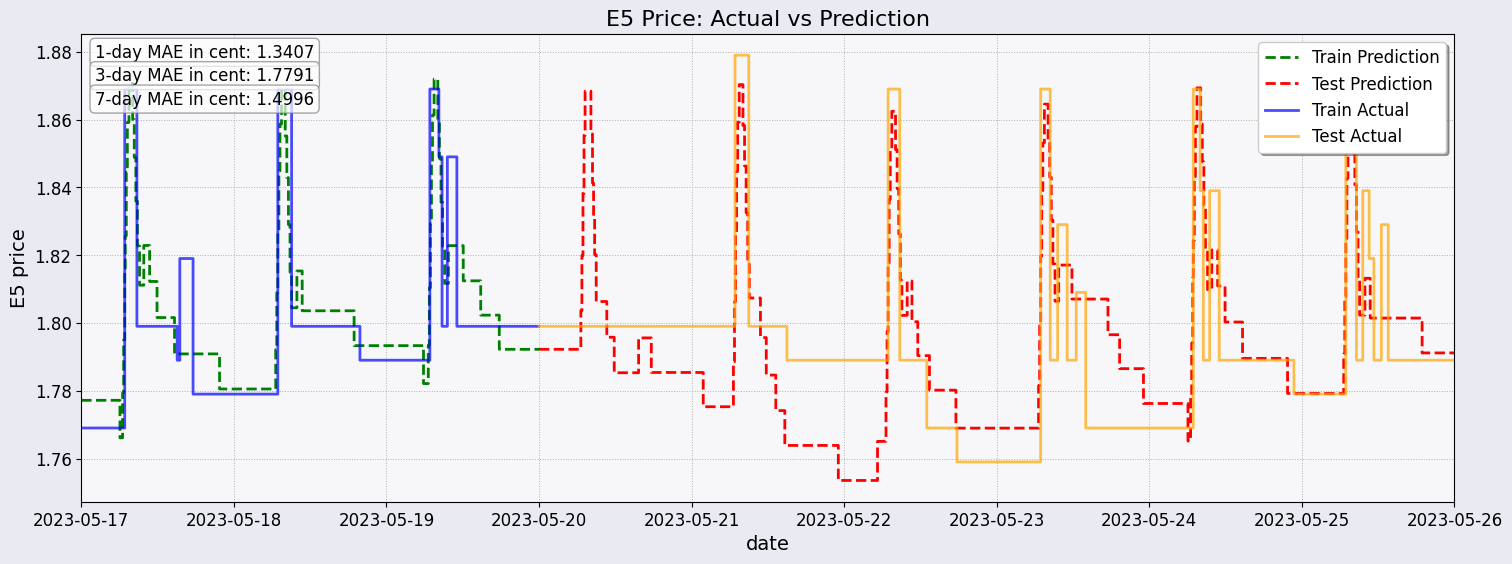

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/24zkjwcu.json


Successfully processed df01

Processing dataset: df02


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/iqzm25pr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89287', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/24zkjwcu.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/iqzm25pr.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model3du7f7k9/prophet_model-20250618205437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:54:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:54:56 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 0.9748
1-Day r2-score: 0.8712
3-Day MAE in cent: 1.2800
3-Day r2-score: 0.7872
7-Day MAE in cent: 1.6490
7-Day r2-score: 0.6269


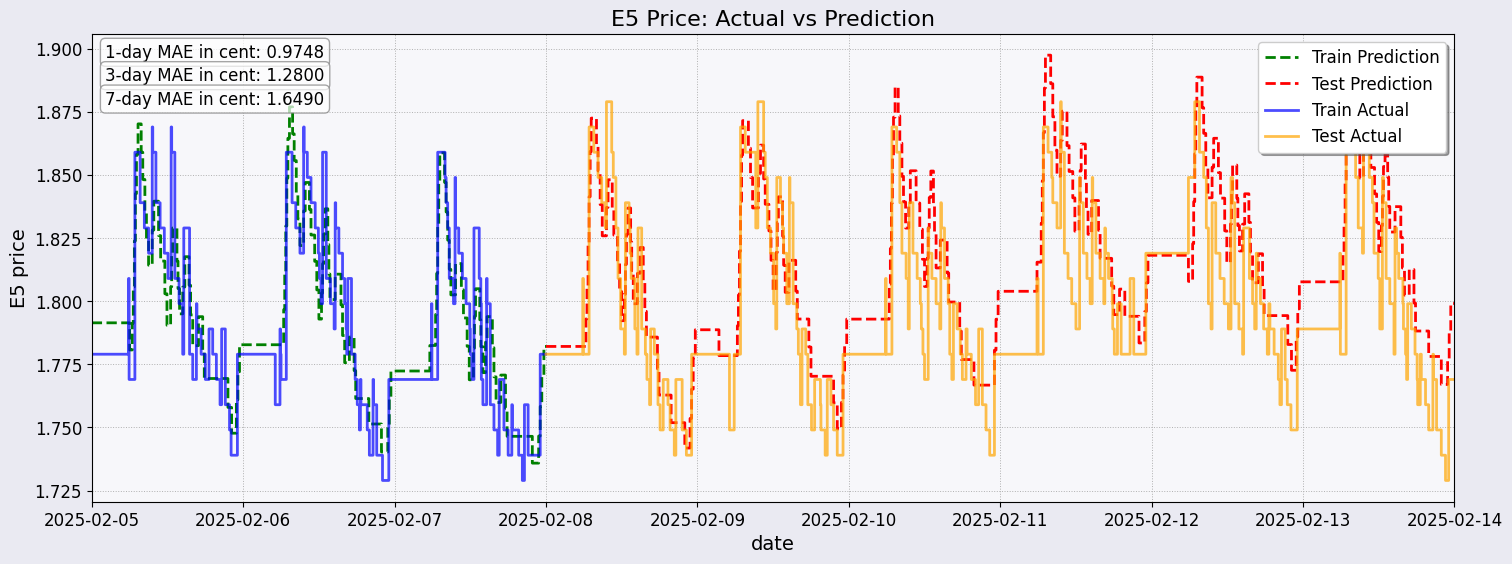

Successfully processed df02

Processing dataset: df03


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/_3c9wxqo.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/i46y91z9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33840', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/_3c9wxqo.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/i46y91z9.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelinp9hkf3/prophet_model-20250618205458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:54:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.8239
1-Day r2-score: 0.5180
3-Day MAE in cent: 2.0774
3-Day r2-score: 0.6094
7-Day MAE in cent: 1.9018
7-Day r2-score: 0.7059


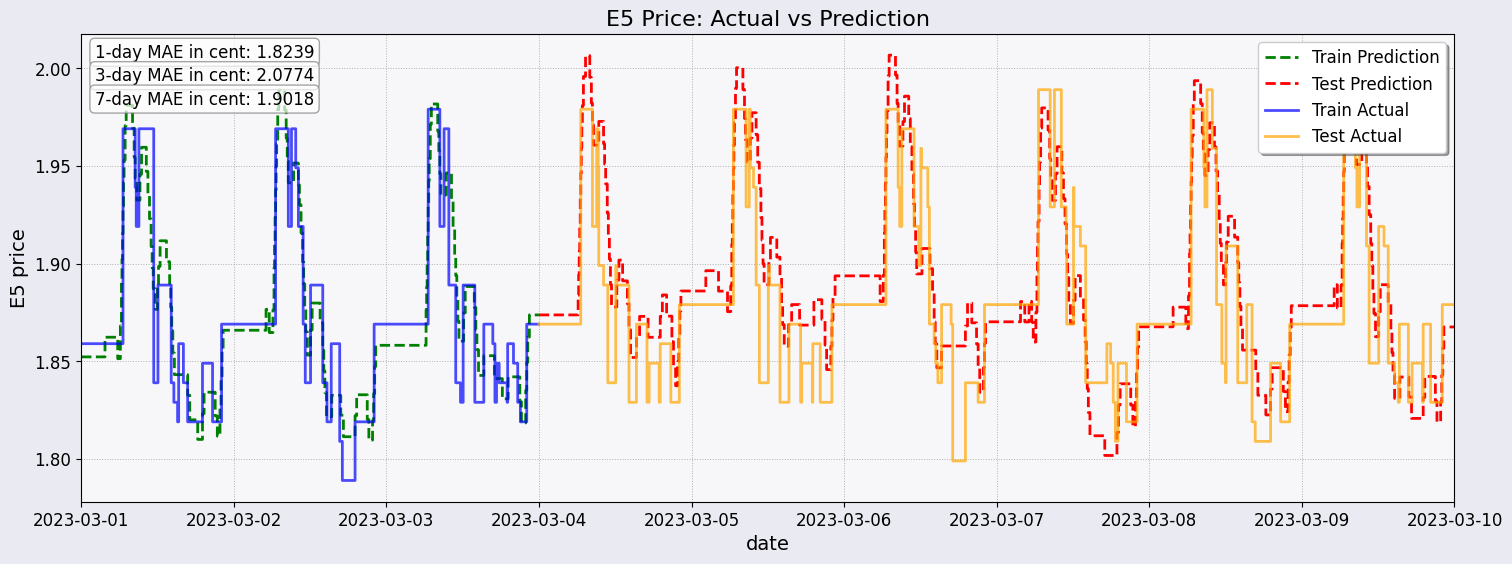

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/3rjqoddu.json


Successfully processed df03

Processing dataset: df04


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/mvfl4gwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90869', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/3rjqoddu.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/mvfl4gwy.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model8jpqtclq/prophet_model-20250618205516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:55:35 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 2.0122
1-Day r2-score: 0.5243
3-Day MAE in cent: 4.0212
3-Day r2-score: -0.3724
7-Day MAE in cent: 5.0711
7-Day r2-score: -1.3400


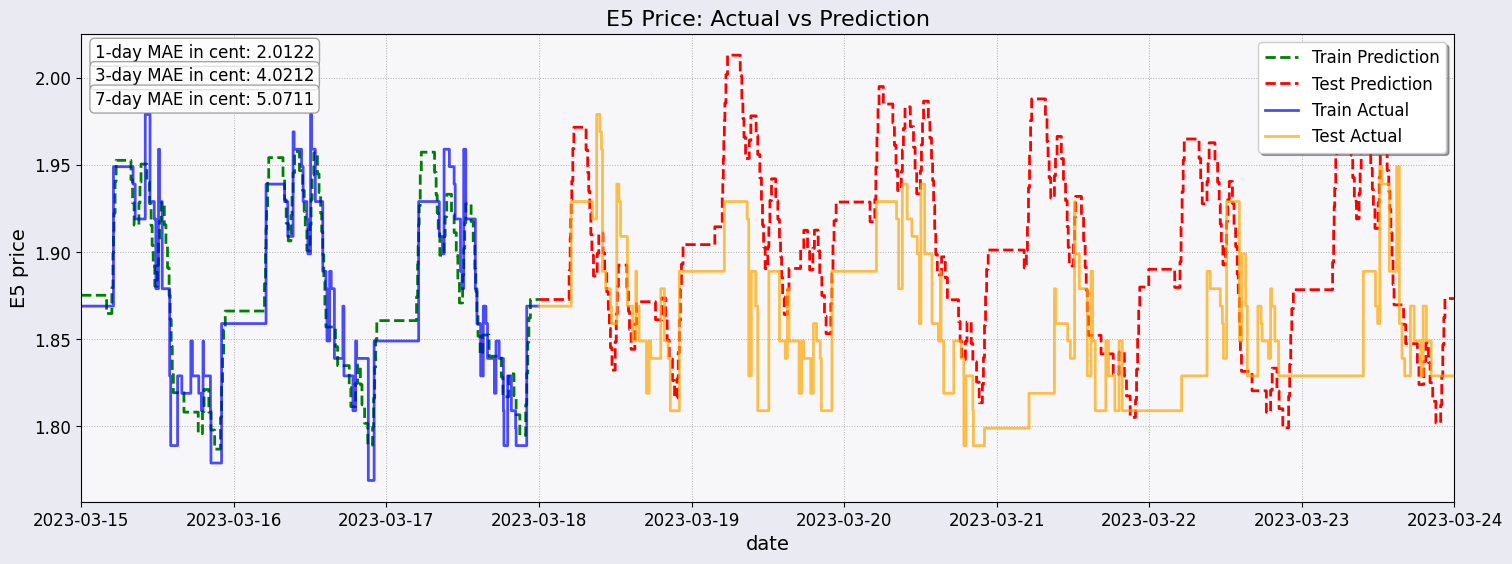

Successfully processed df04

Processing dataset: df05


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/l444131l.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/zljesu8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51014', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/l444131l.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/zljesu8f.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelk0_nbsps/prophet_model-20250618205537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 4.9895
1-Day r2-score: -3.7649
3-Day MAE in cent: 3.8899
3-Day r2-score: -2.0502
7-Day MAE in cent: 3.7391
7-Day r2-score: -0.9404


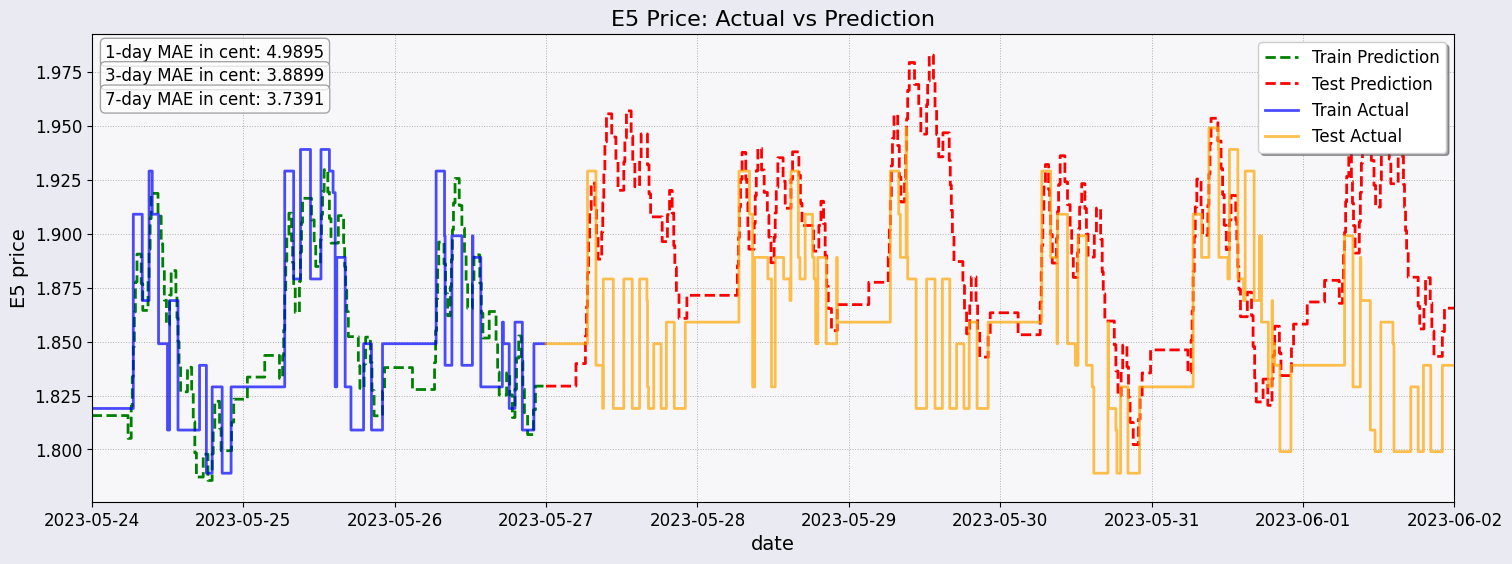

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/_on8a6h2.json


Successfully processed df05

Processing dataset: df06


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/df6b_7il.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52614', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/_on8a6h2.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/df6b_7il.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelxnovm6hy/prophet_model-20250618205558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:56:10 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 2.1374
1-Day r2-score: 0.0505
3-Day MAE in cent: 2.1658
3-Day r2-score: 0.4583
7-Day MAE in cent: 2.1866
7-Day r2-score: 0.4426


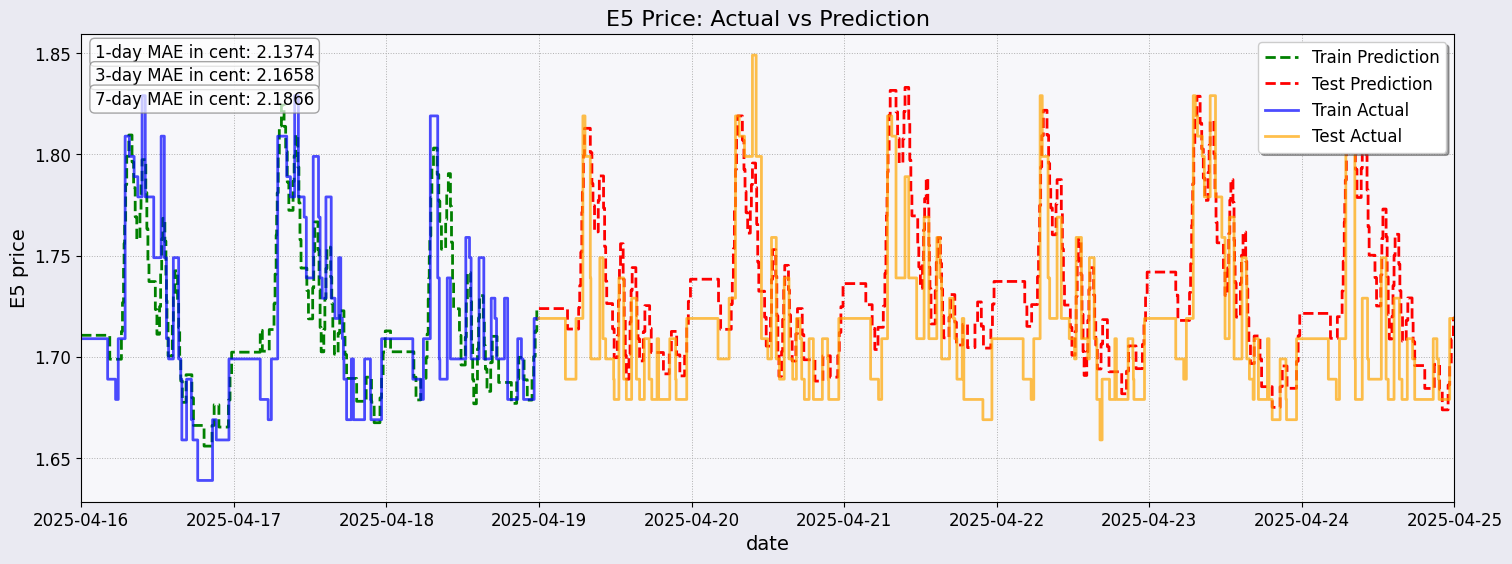

Successfully processed df06

Processing dataset: df07


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/4v4pnw9s.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/7pdf56bc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98037', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/4v4pnw9s.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/7pdf56bc.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model7d74e_6v/prophet_model-20250618205611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.6982
1-Day r2-score: 0.3726
3-Day MAE in cent: 1.9131
3-Day r2-score: 0.3509
7-Day MAE in cent: 1.9181
7-Day r2-score: 0.5174


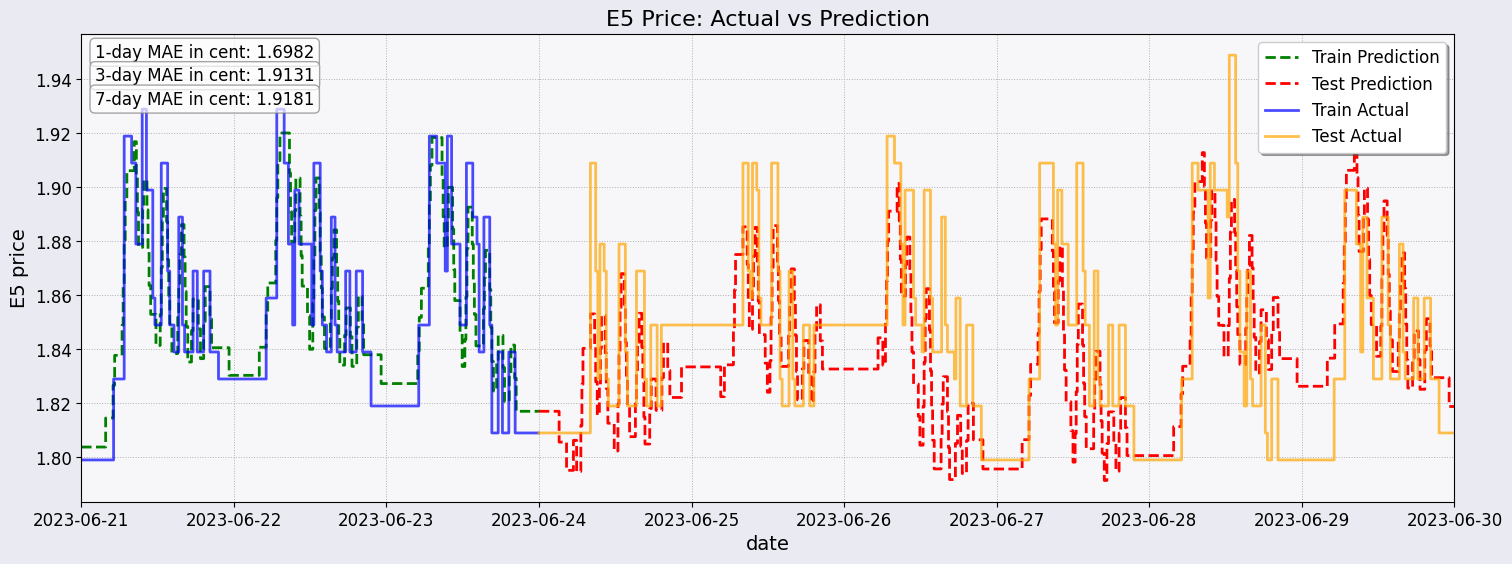

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/m559pv74.json


Successfully processed df07

Processing dataset: df08


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/hx57dvi2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2058', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/m559pv74.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/hx57dvi2.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelaxz5pdvb/prophet_model-20250618205626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:56:42 WARNING mlflow.models.model: Model logged without a signature and inpu

1-Day MAE in cent: 3.4255
1-Day r2-score: -1.5164
3-Day MAE in cent: 6.0958
3-Day r2-score: -9.8291
7-Day MAE in cent: 9.4541
7-Day r2-score: -19.4713


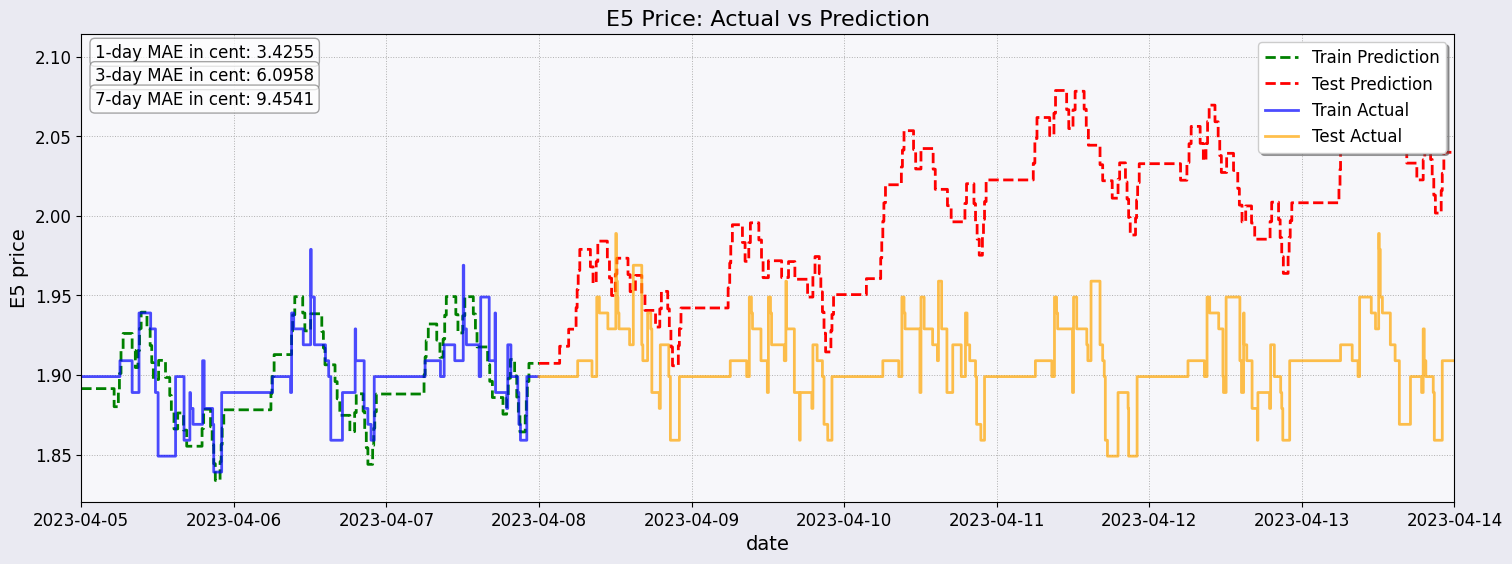

Successfully processed df08

Processing dataset: df09


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/4oahl3_j.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/cwjhv14p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7612', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/4oahl3_j.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/cwjhv14p.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelpdjfhgah/prophet_model-20250618205644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1]

1-Day MAE in cent: 1.3850
1-Day r2-score: 0.6811
3-Day MAE in cent: 3.0317
3-Day r2-score: 0.0552
7-Day MAE in cent: 2.4655
7-Day r2-score: 0.3208


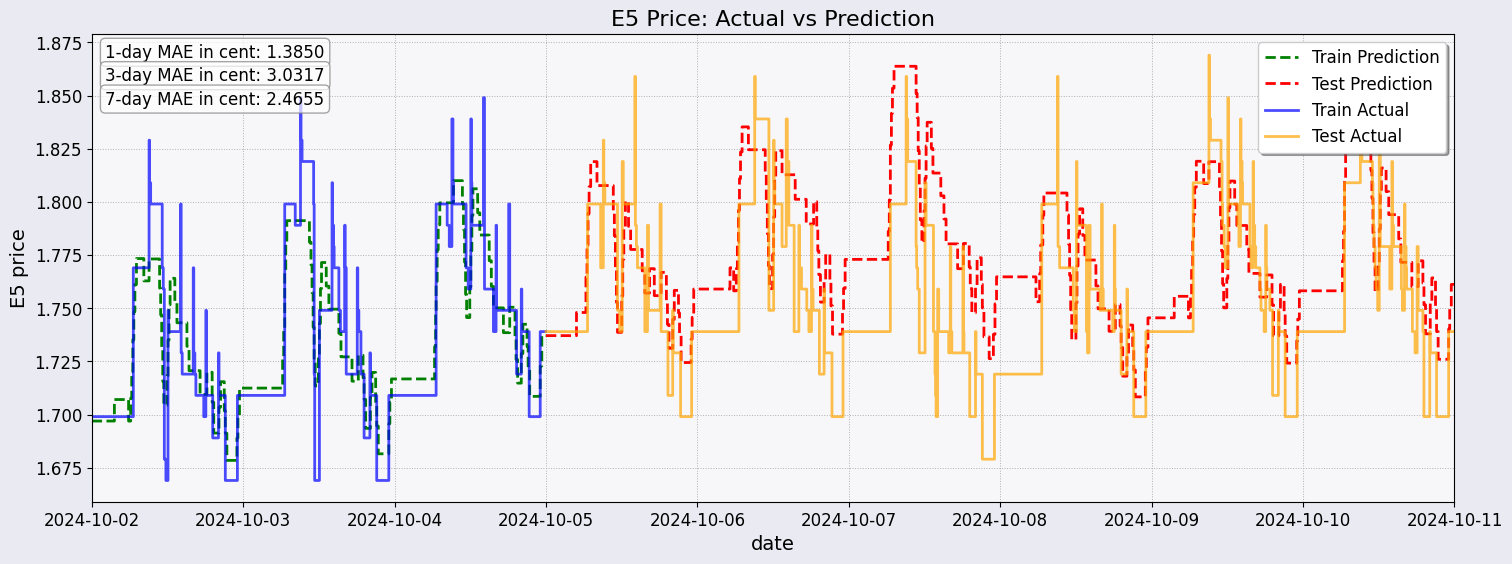

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/v0b3rg_k.json


Successfully processed df09

Processing dataset: df10


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/er1ztxqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68606', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/v0b3rg_k.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/er1ztxqq.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelu0bneulf/prophet_model-20250618205659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:57:15 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.3507
1-Day r2-score: 0.5465
3-Day MAE in cent: 2.2276
3-Day r2-score: 0.0718
7-Day MAE in cent: 3.3307
7-Day r2-score: -0.5498


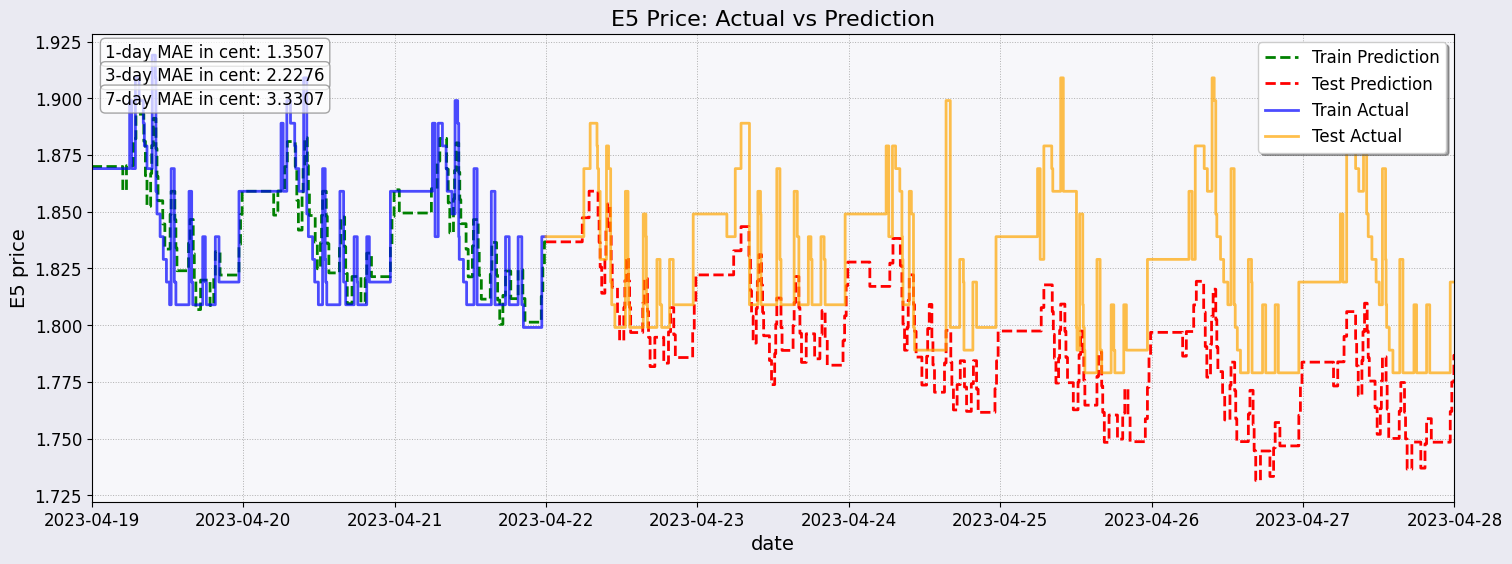

Successfully processed df10

Processing dataset: df11


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/ewx_887e.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/okqt88c7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52966', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/ewx_887e.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/okqt88c7.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model8cdoxq6n/prophet_model-20250618205717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:57:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:57:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.2665
1-Day r2-score: 0.7812
3-Day MAE in cent: 4.0410
3-Day r2-score: 0.3059
7-Day MAE in cent: 3.9362
7-Day r2-score: 0.2688


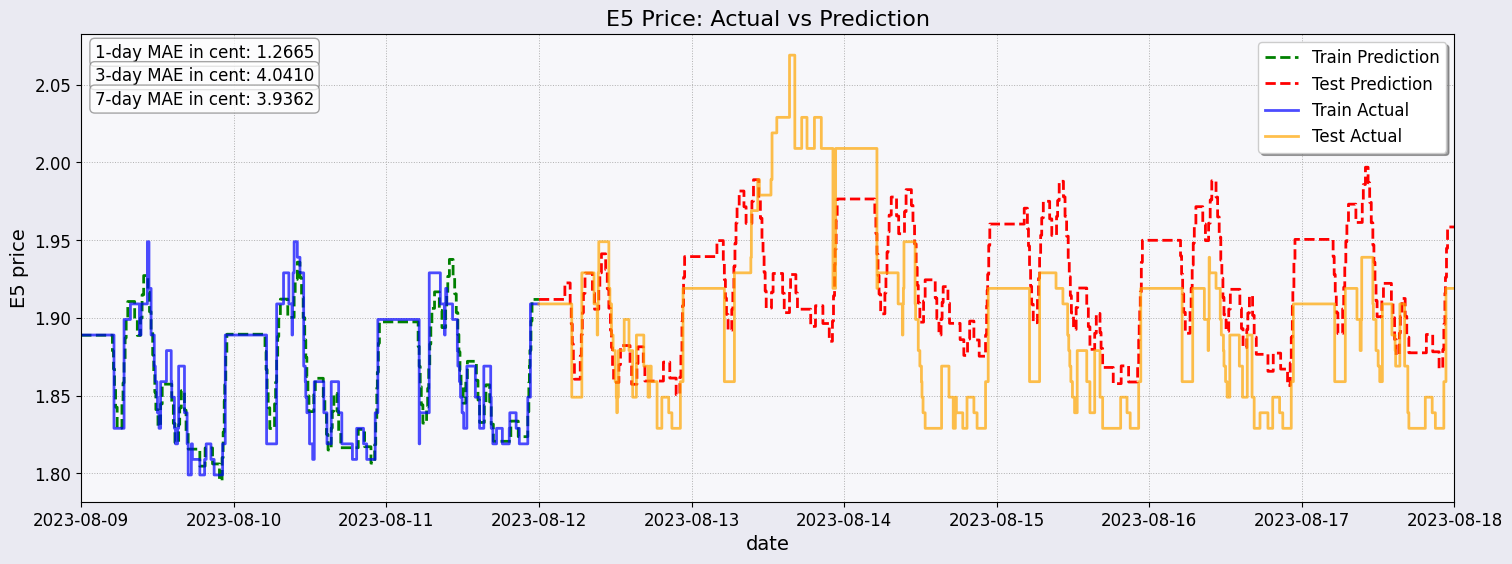

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/1md_vem5.json


Successfully processed df11

Processing dataset: df12


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/somztluh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36461', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/1md_vem5.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/somztluh.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model526h2v3r/prophet_model-20250618205739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:57:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:57:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:57:58 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.0874
1-Day r2-score: 0.7691
3-Day MAE in cent: 1.8288
3-Day r2-score: 0.6053
7-Day MAE in cent: 2.2827
7-Day r2-score: 0.4543


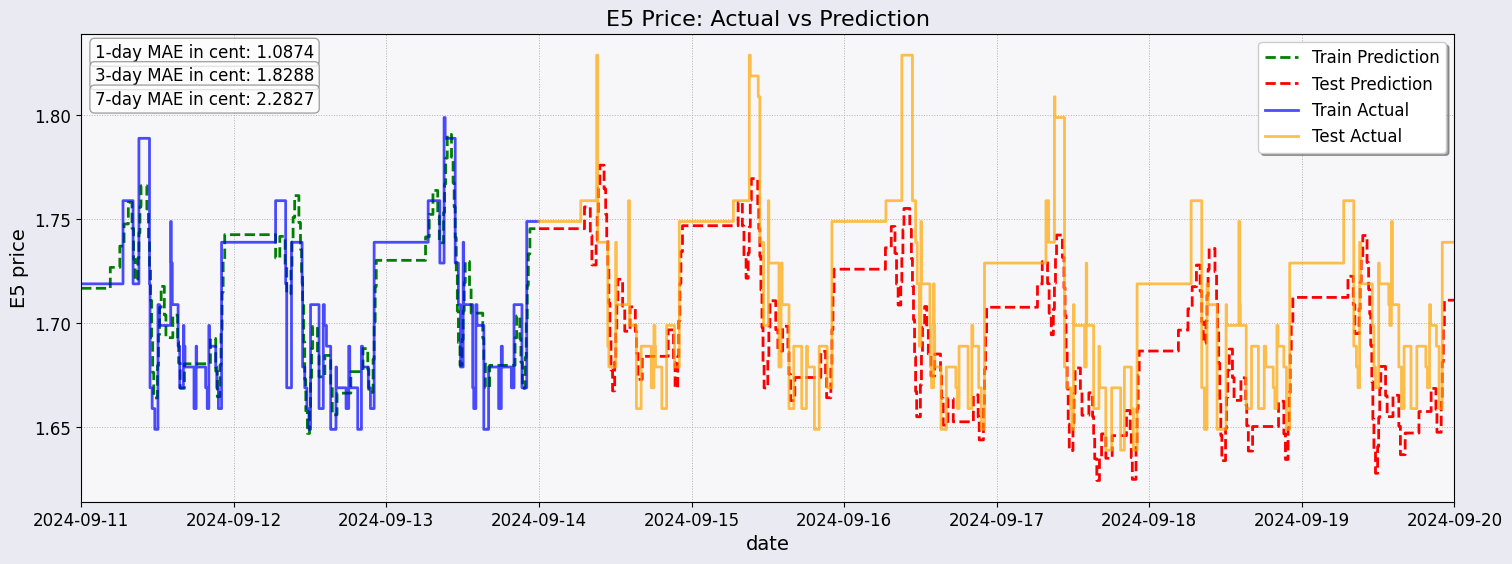

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/ylzxxzkg.json


Successfully processed df12

Processing dataset: df13


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/i9it_oma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76398', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/ylzxxzkg.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/i9it_oma.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model65f5enkq/prophet_model-20250618205759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:57:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:58:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:58:18 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.8032
1-Day r2-score: 0.5704
3-Day MAE in cent: 2.3775
3-Day r2-score: 0.3545
7-Day MAE in cent: 1.8949
7-Day r2-score: 0.4953


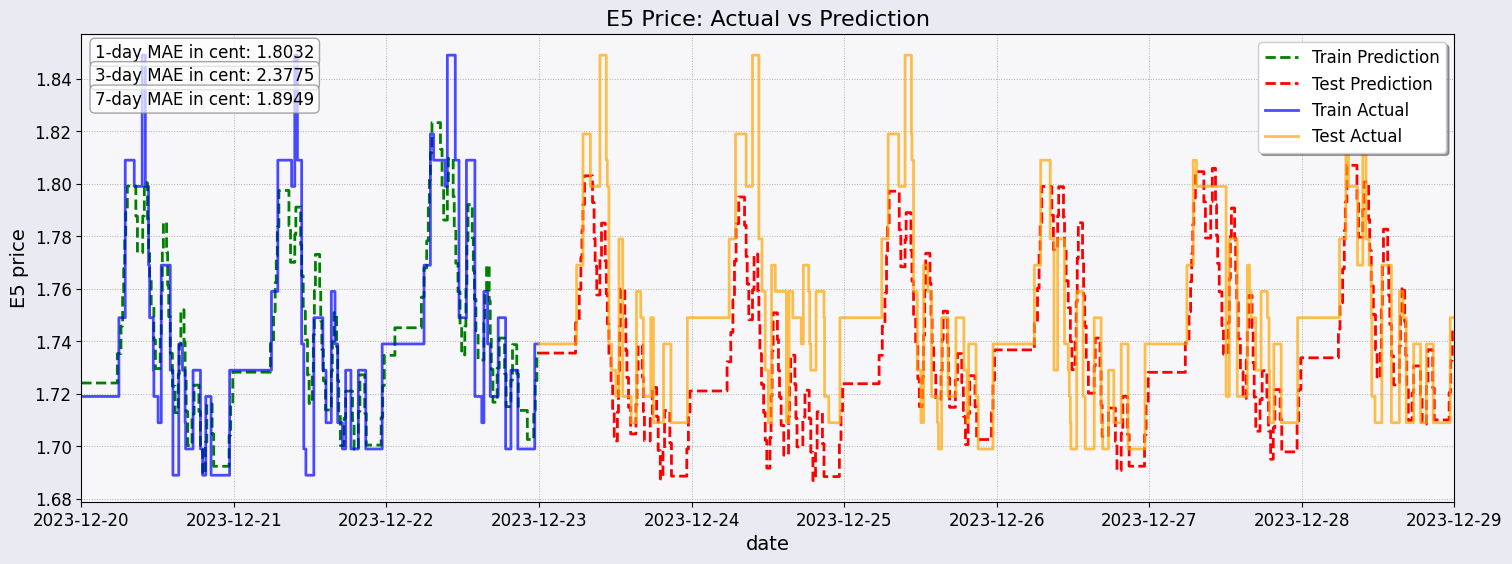

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/y4eo1wxz.json


Successfully processed df13

Processing dataset: df14


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/ecbeywya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45258', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/y4eo1wxz.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/ecbeywya.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modeljhoeyqyq/prophet_model-20250618205820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:58:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:58:38 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.9145
1-Day r2-score: 0.4225
3-Day MAE in cent: 1.9617
3-Day r2-score: 0.5396
7-Day MAE in cent: 3.2567
7-Day r2-score: 0.0992


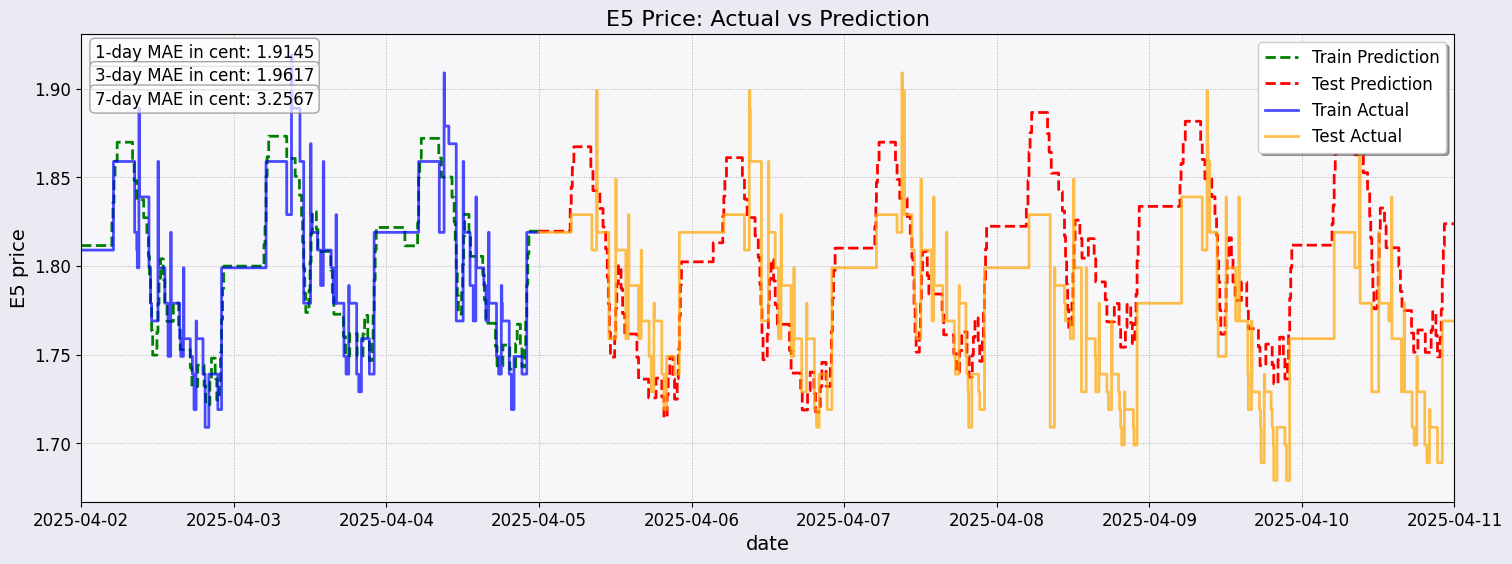

Successfully processed df14

Processing dataset: df15


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/wpnhytg3.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/l5q289mc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70605', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/wpnhytg3.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/l5q289mc.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelsrmqa4_i/prophet_model-20250618205839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:58:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:58:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.4940
1-Day r2-score: 0.1575
3-Day MAE in cent: 1.4693
3-Day r2-score: 0.3310
7-Day MAE in cent: 1.8478
7-Day r2-score: 0.1532


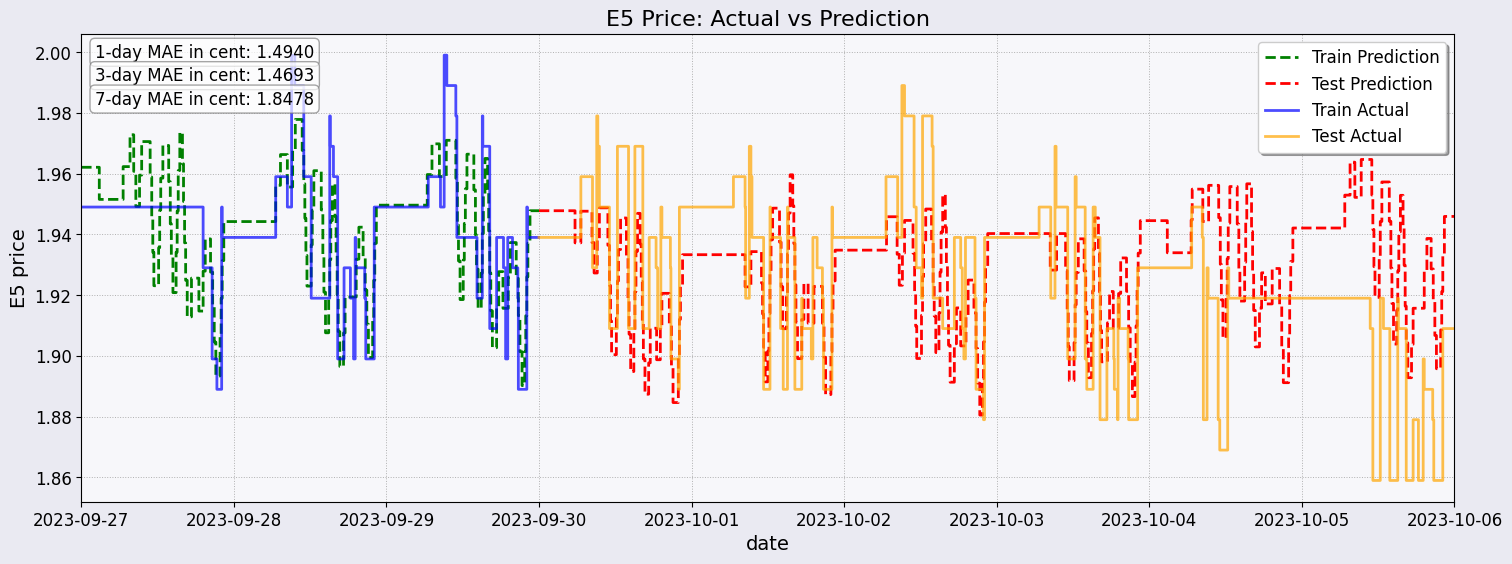

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/q2vzppw1.json


Successfully processed df15

Processing dataset: df16


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/3lhkv7c0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91541', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/q2vzppw1.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/3lhkv7c0.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modeljfv7mtvp/prophet_model-20250618205900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:59:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:59:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:59:21 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 3.0419
1-Day r2-score: -0.2769
3-Day MAE in cent: 3.9774
3-Day r2-score: -1.1134
7-Day MAE in cent: 3.2965
7-Day r2-score: -0.6383


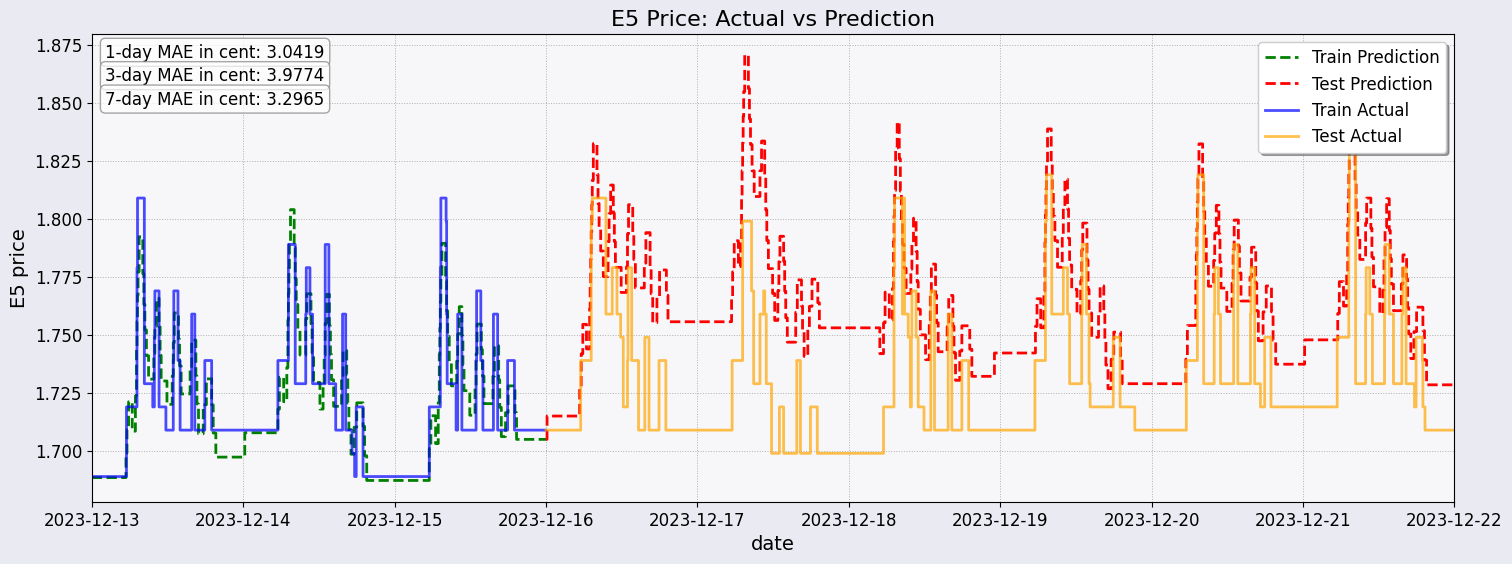

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/43wro1cm.json


Successfully processed df16

Processing dataset: df17


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/k3m90xvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94776', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/43wro1cm.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/k3m90xvl.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelavx3tyo4/prophet_model-20250618205922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:59:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:59:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 20:59:44 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 0.1239
1-Day r2-score: 0.6498
3-Day MAE in cent: 0.2016
3-Day r2-score: -0.6021
7-Day MAE in cent: 1.9077
7-Day r2-score: -1.6917


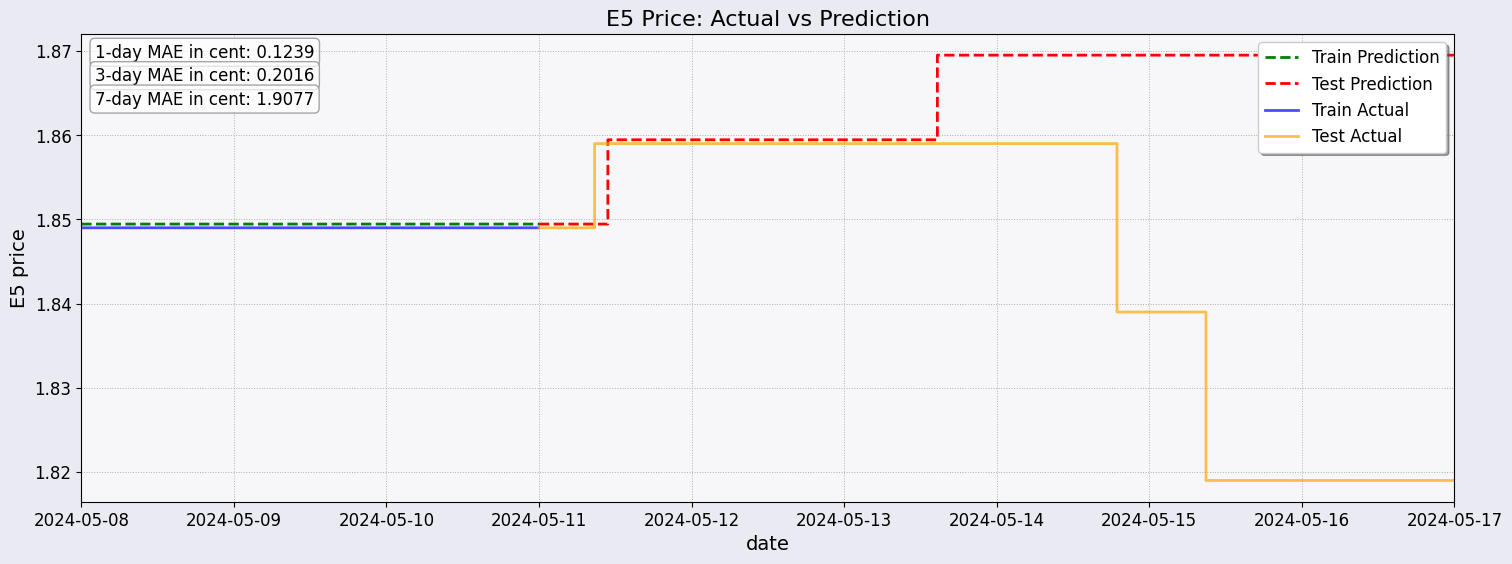

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/v0ffpaol.json


Successfully processed df17

Processing dataset: df18


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/g2xuvzgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90865', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/v0ffpaol.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/g2xuvzgd.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelqkgef757/prophet_model-20250618205945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:59:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 21:00:02 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.4105
1-Day r2-score: 0.4419
3-Day MAE in cent: 2.0087
3-Day r2-score: 0.5158
7-Day MAE in cent: 2.1159
7-Day r2-score: 0.6392


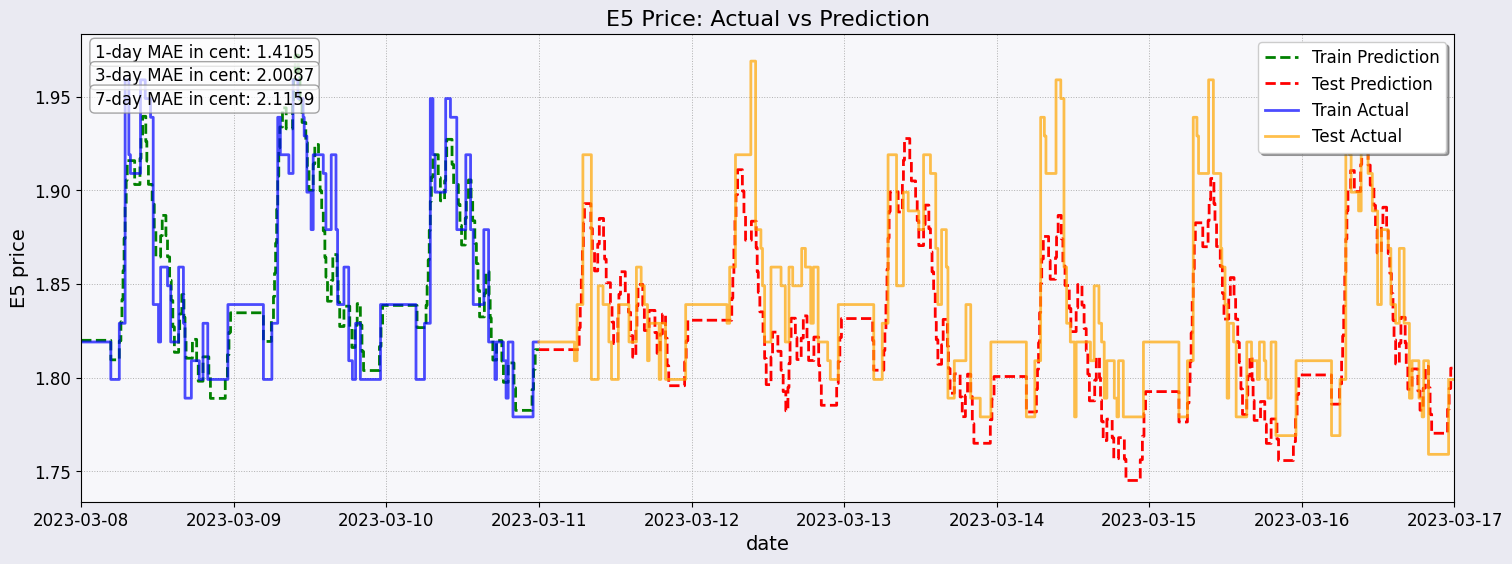

Successfully processed df18

Processing dataset: df19


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/gokyiglx.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/u89lx46n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85497', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/gokyiglx.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/u89lx46n.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelcivila8m/prophet_model-20250618210003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:00:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 0.9052
1-Day r2-score: 0.6920
3-Day MAE in cent: 1.3907
3-Day r2-score: 0.3099
7-Day MAE in cent: 2.9294
7-Day r2-score: -1.6047


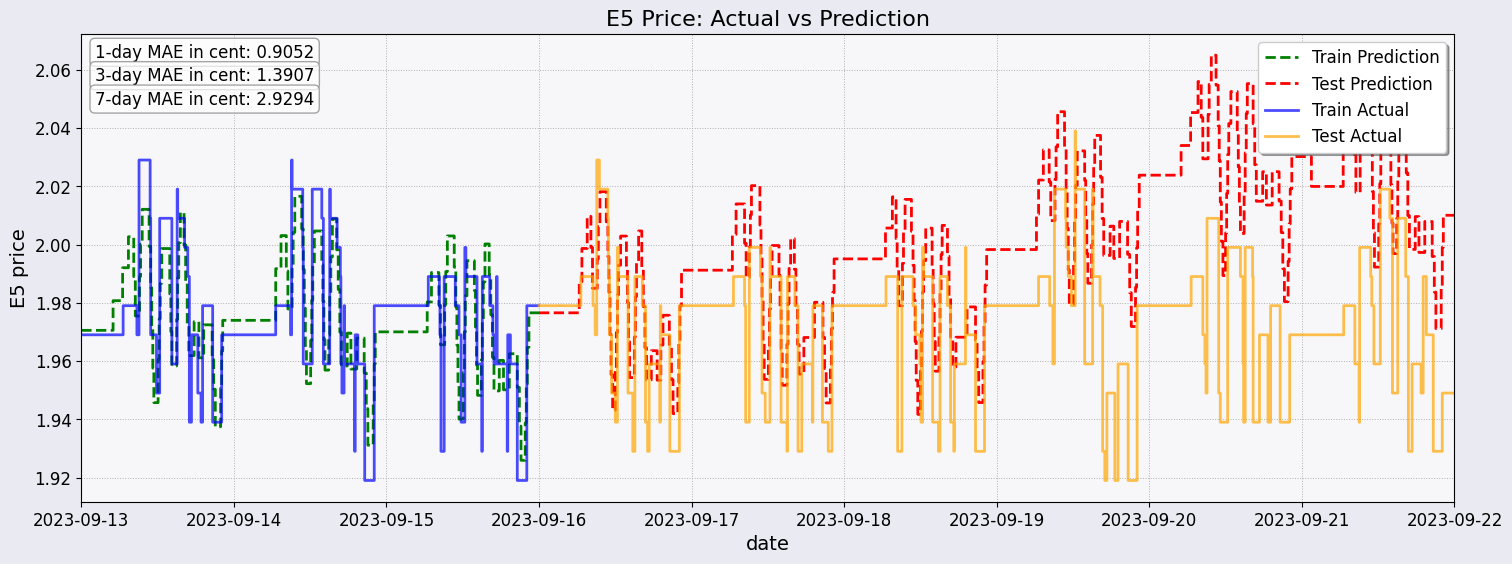

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/lse_3idf.json


Successfully processed df19

Processing dataset: df20


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/mg06gjlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40416', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/lse_3idf.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/mg06gjlr.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelga32yzav/prophet_model-20250618210020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 21:00:42 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.3801
1-Day r2-score: 0.7194
3-Day MAE in cent: 1.6040
3-Day r2-score: 0.7789
7-Day MAE in cent: 2.2845
7-Day r2-score: 0.5975


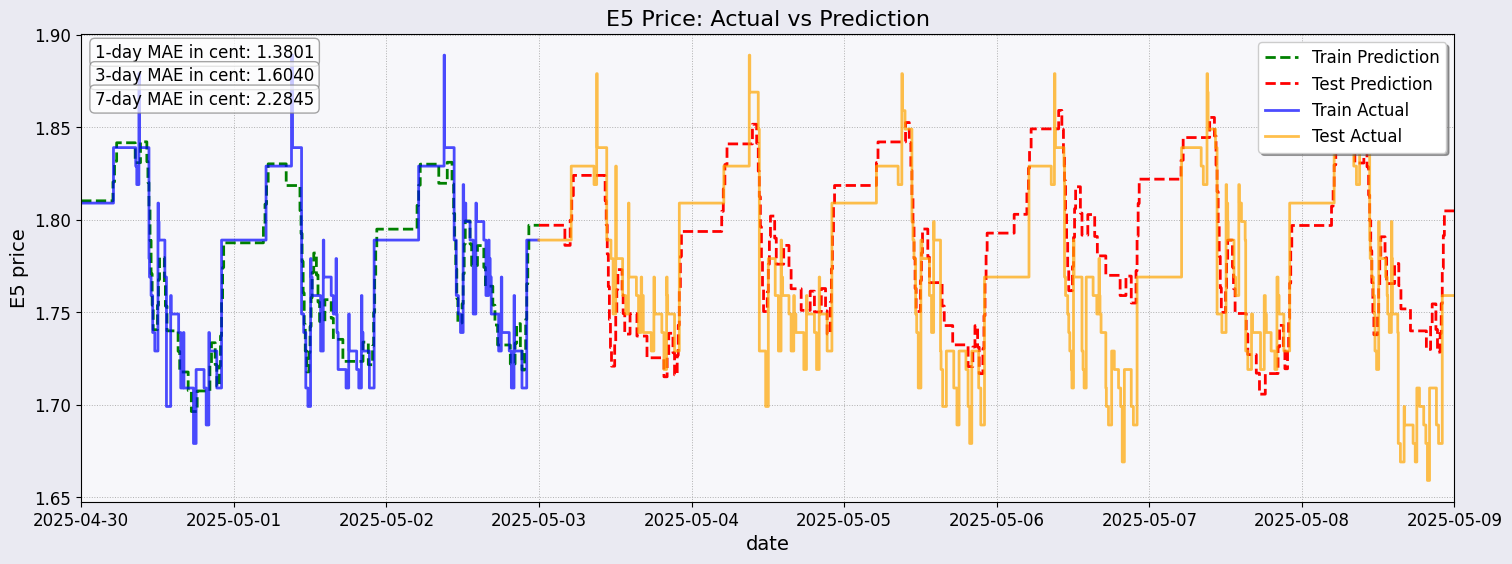

Successfully processed df20

Processing dataset: df21


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/shxsdw3l.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/i0mregak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38936', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/shxsdw3l.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/i0mregak.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelj60pkmi1/prophet_model-20250618210043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.4879
1-Day r2-score: 0.6119
3-Day MAE in cent: 1.4256
3-Day r2-score: 0.5813
7-Day MAE in cent: 2.3005
7-Day r2-score: 0.2718


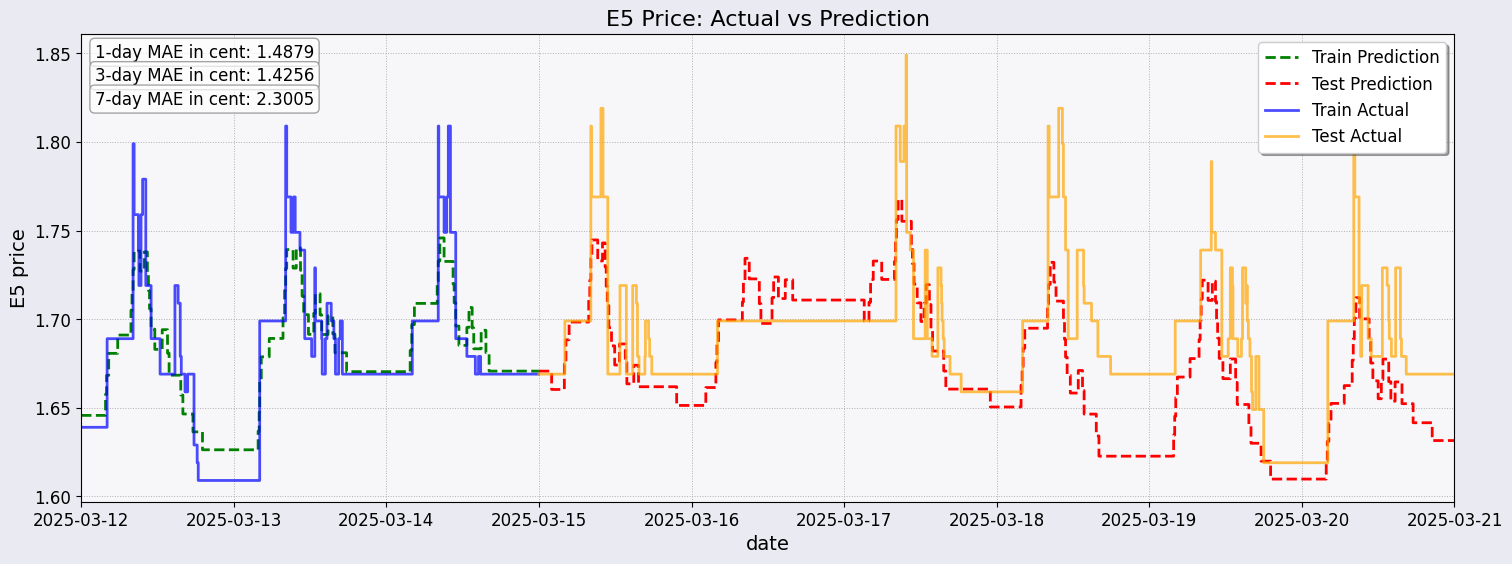

Successfully processed df21

Processing dataset: df22


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/08gwzo99.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/wl3xd_dt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9591', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/08gwzo99.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/wl3xd_dt.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelam1g5thi/prophet_model-20250618210100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:01:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:01:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1]

1-Day MAE in cent: 2.6819
1-Day r2-score: -0.1897
3-Day MAE in cent: 3.5156
3-Day r2-score: -0.6396
7-Day MAE in cent: 3.2873
7-Day r2-score: -0.5070


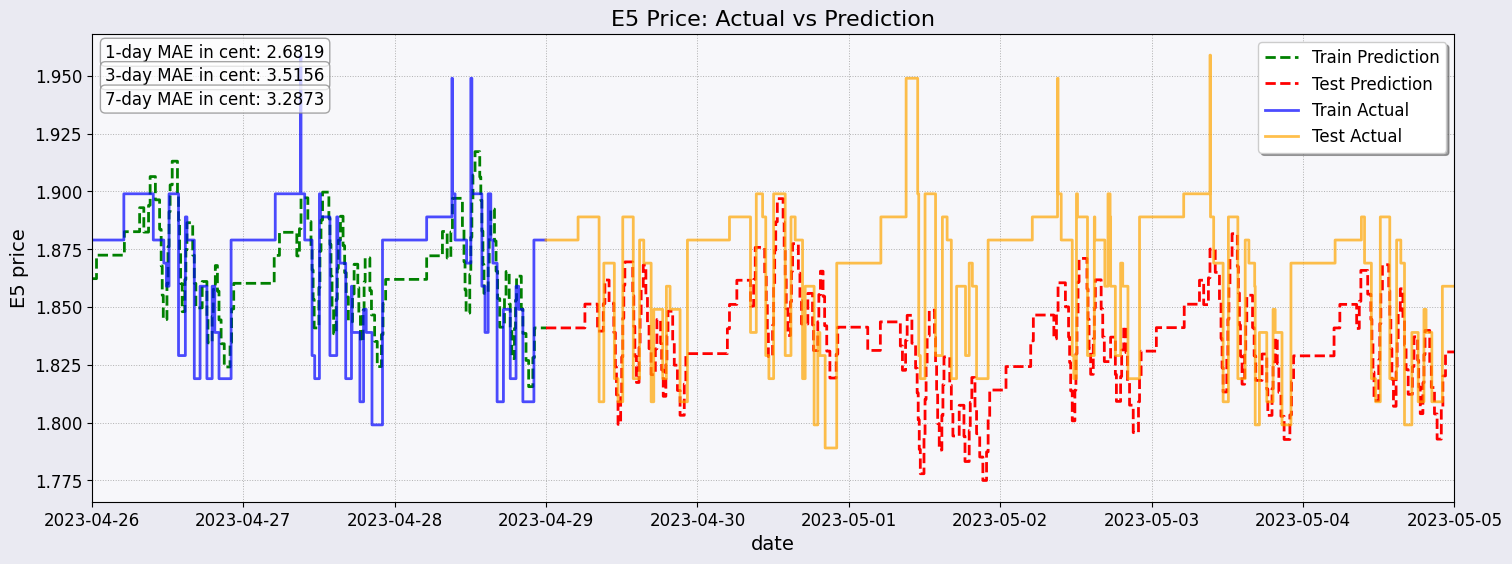

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/tit8rg83.json


Successfully processed df22

Processing dataset: df23


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/z17yjlh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73298', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/tit8rg83.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/z17yjlh0.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model3ll8274p/prophet_model-20250618210114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:01:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:01:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 21:01:36 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.5358
1-Day r2-score: 0.5888
3-Day MAE in cent: 1.6341
3-Day r2-score: 0.6515
7-Day MAE in cent: 1.9768
7-Day r2-score: 0.2720


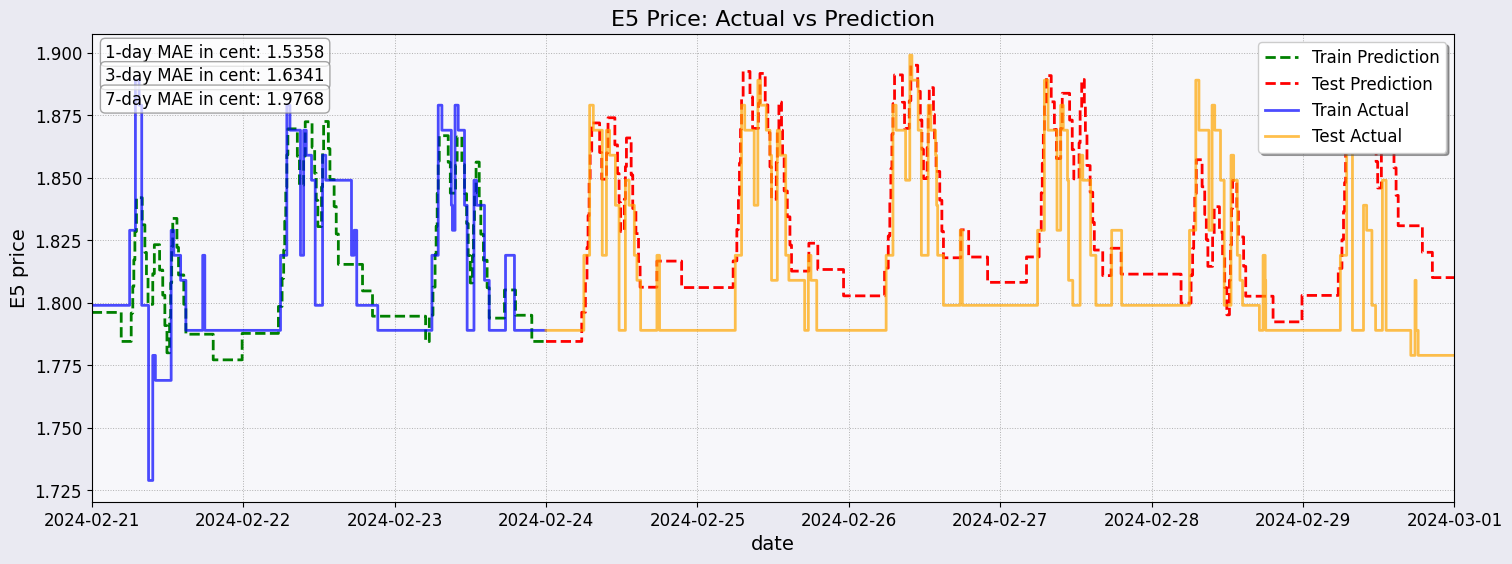

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/nd_s7wtu.json


Successfully processed df23

Processing dataset: df24


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/b02hszcv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3582', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/nd_s7wtu.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/b02hszcv.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model749dui7t/prophet_model-20250618210137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:01:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:01:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 21:01:58 WARNING mlflow.models.model: Model logged without a signature and inpu

1-Day MAE in cent: 3.0610
1-Day r2-score: -2.8628
3-Day MAE in cent: 4.5268
3-Day r2-score: -11.2487
7-Day MAE in cent: 5.9989
7-Day r2-score: -8.0872


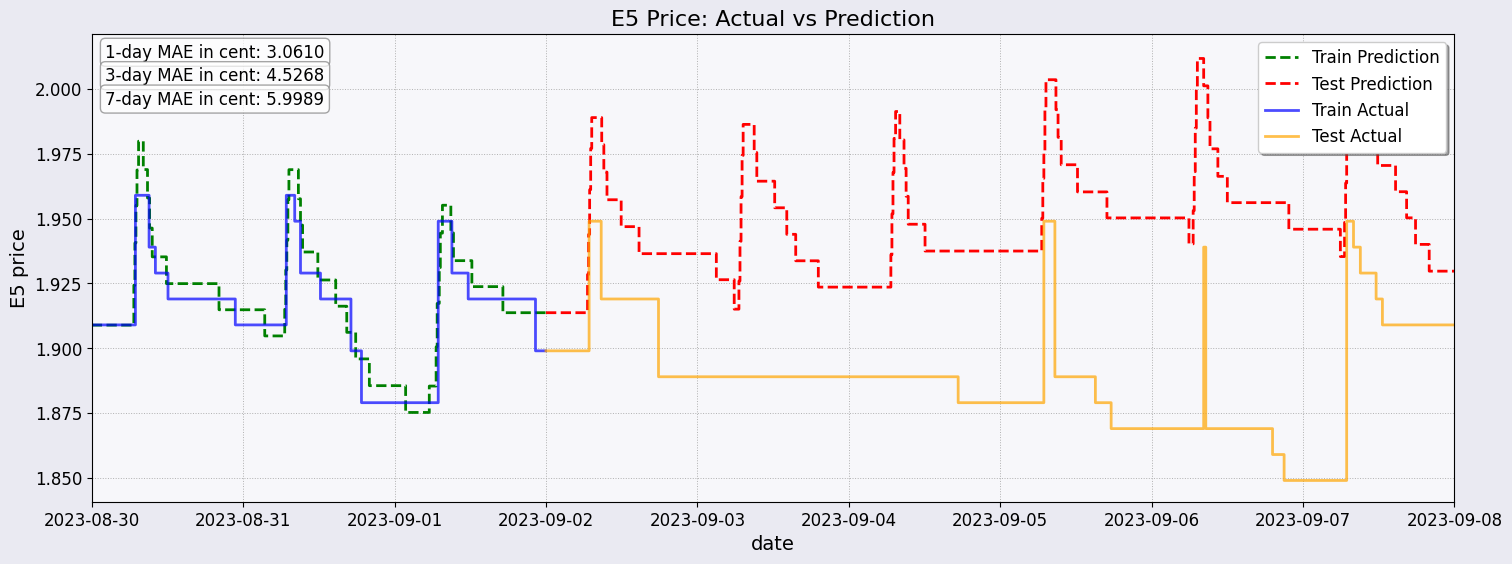

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/k0vb12dy.json


Successfully processed df24

Processing dataset: df25


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/1i8uk4hr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58409', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/k0vb12dy.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/1i8uk4hr.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model9tzjwbps/prophet_model-20250618210159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:01:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 21:02:22 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 4.0548
1-Day r2-score: -0.1390
3-Day MAE in cent: 4.8528
3-Day r2-score: -0.6408
7-Day MAE in cent: 6.7600
7-Day r2-score: -2.4288


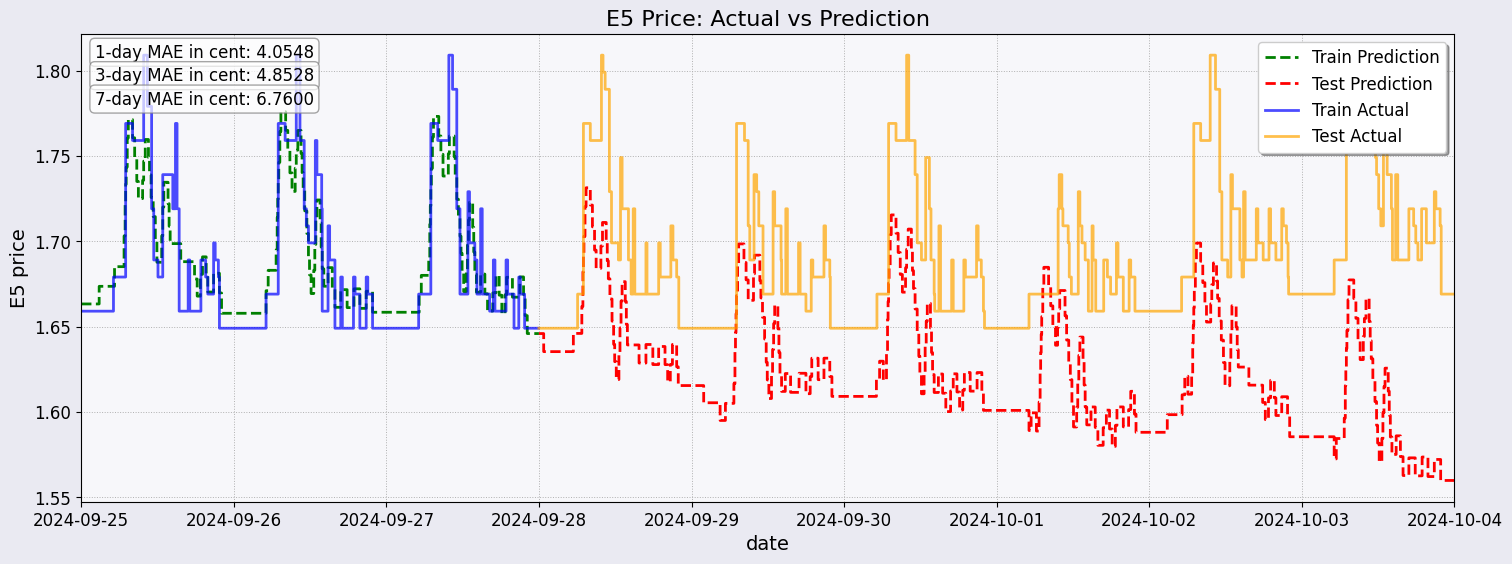

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/13kibkri.json


Successfully processed df25

Processing dataset: df26


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/4p2i22yx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63480', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/13kibkri.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/4p2i22yx.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model6gdfkelm/prophet_model-20250618210223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:02:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 21:02:45 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 3.7242
1-Day r2-score: -0.7781
3-Day MAE in cent: 4.1054
3-Day r2-score: -0.7544
7-Day MAE in cent: 3.3879
7-Day r2-score: 0.1718


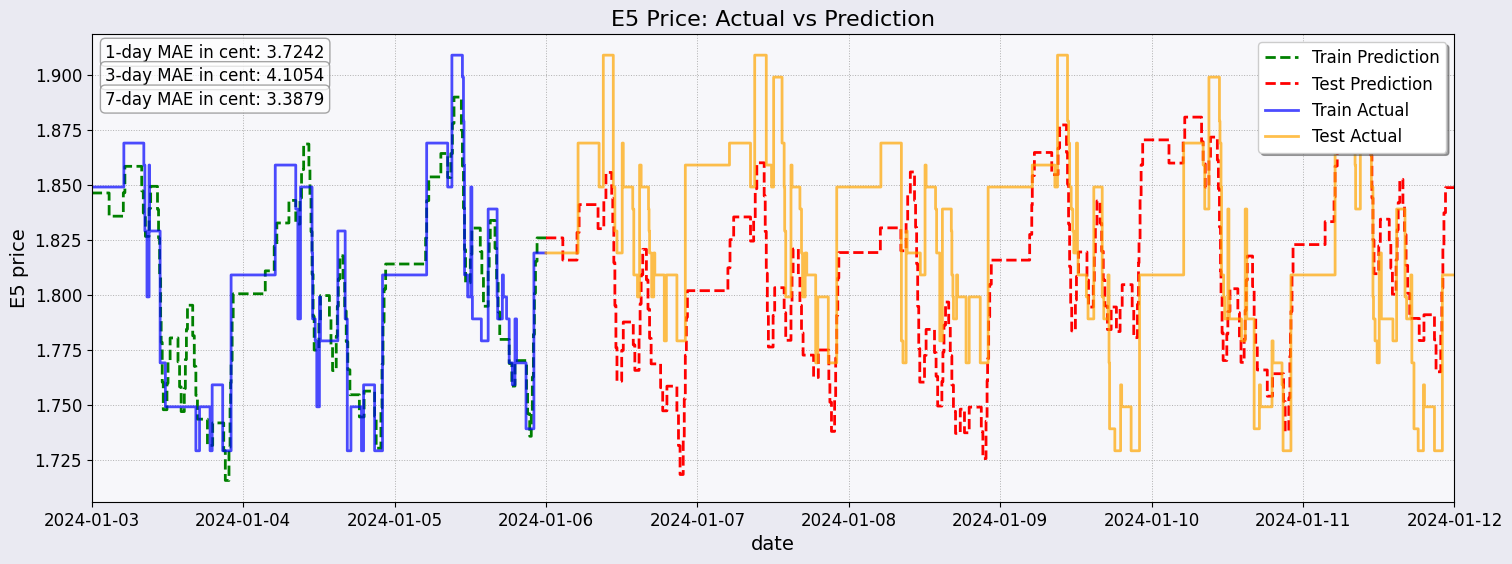

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/c8nx7i5z.json


Successfully processed df26

Processing dataset: df27


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/vrix4fib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35991', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/c8nx7i5z.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/vrix4fib.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model2fvz7p7g/prophet_model-20250618210246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:02:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:03:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 21:03:04 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 0.8620
1-Day r2-score: 0.8142
3-Day MAE in cent: 1.2900
3-Day r2-score: 0.6985
7-Day MAE in cent: 1.4482
7-Day r2-score: 0.6244


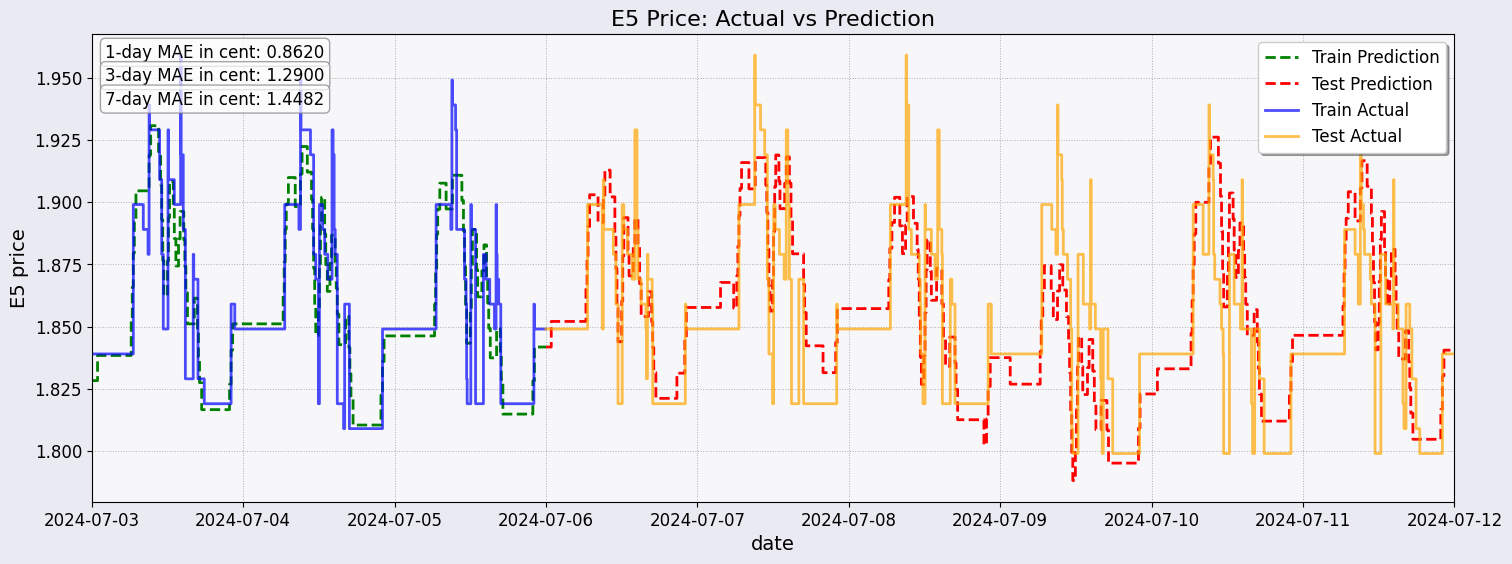

Successfully processed df27

Processing dataset: df28


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/z5uoas3q.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/ogwu42ce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6652', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/z5uoas3q.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/ogwu42ce.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_modelh7eizys_/prophet_model-20250618210306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:03:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:03:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1]

1-Day MAE in cent: 1.6552
1-Day r2-score: 0.8455
3-Day MAE in cent: 1.9438
3-Day r2-score: 0.7533
7-Day MAE in cent: 2.8020
7-Day r2-score: 0.4737


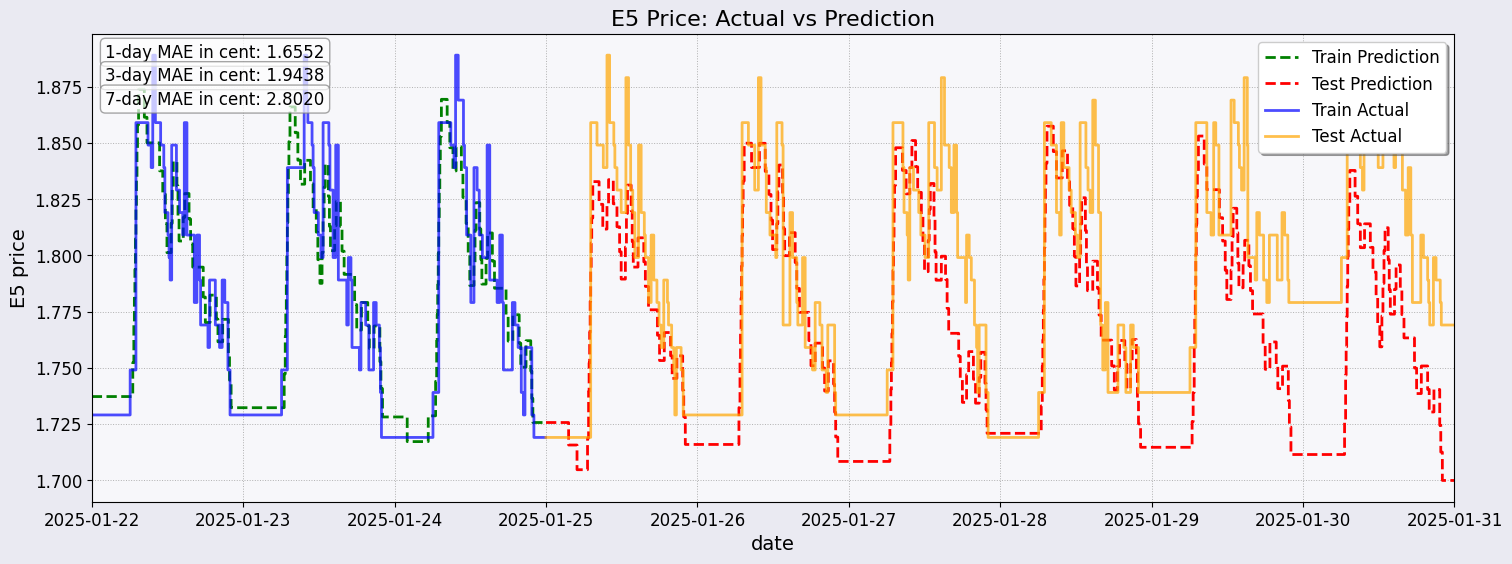

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/q0u72t5c.json


Successfully processed df28

Processing dataset: df29


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/2w7baj7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93683', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/q0u72t5c.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/2w7baj7m.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_models8cuzh4i/prophet_model-20250618210328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:03:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:03:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 21:03:49 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.7189
1-Day r2-score: 0.5084
3-Day MAE in cent: 1.4944
3-Day r2-score: 0.5696
7-Day MAE in cent: 2.9467
7-Day r2-score: -0.5919


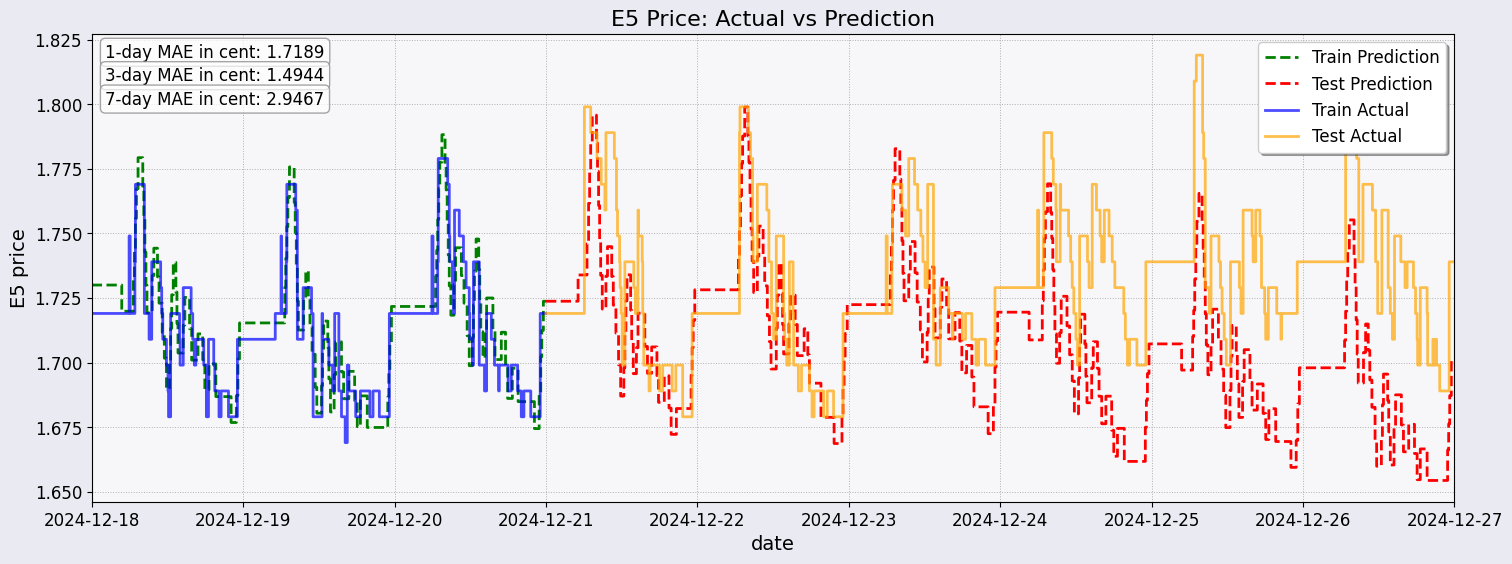

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/1ya5157v.json


Successfully processed df29

Processing dataset: df30


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/mni5k7ah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13099', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/1ya5157v.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/mni5k7ah.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpayxq3b5t/prophet_model9ef3l7mr/prophet_model-20250618210350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:03:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 21:04:11 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 3.8657
1-Day r2-score: -1.1992
3-Day MAE in cent: 5.2137
3-Day r2-score: -2.3927
7-Day MAE in cent: 5.3064
7-Day r2-score: -2.1587


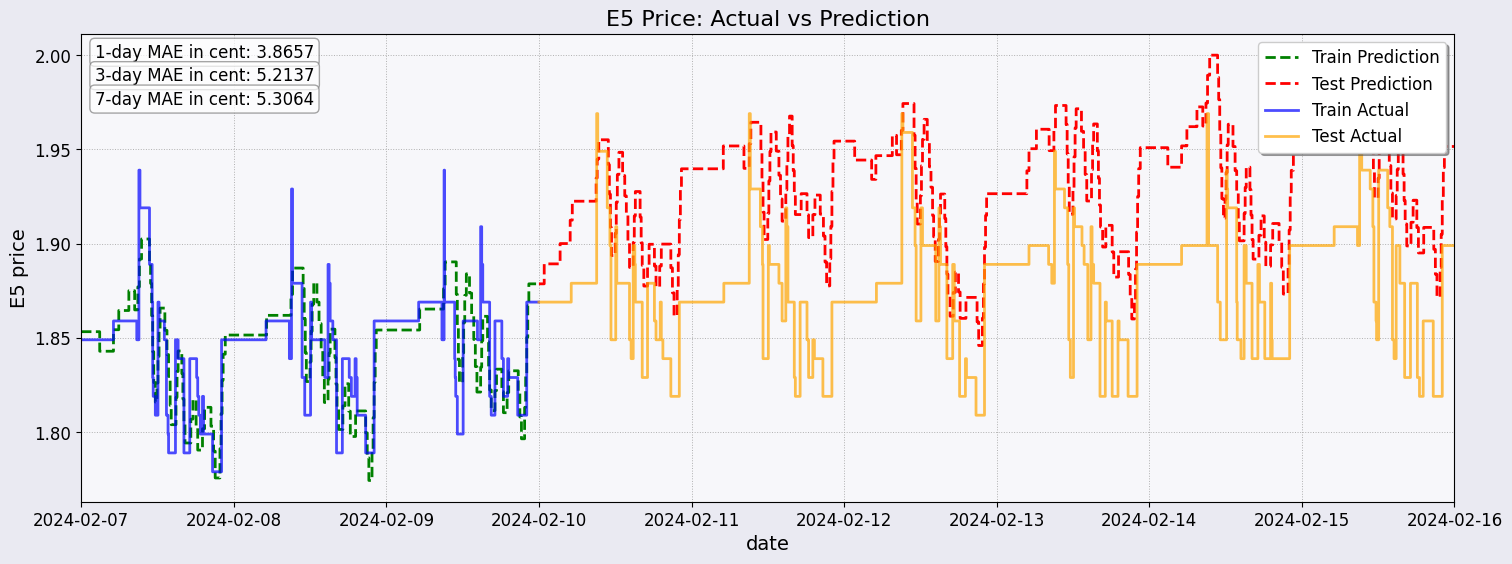

Successfully processed df30

=== Error Summary ===
All datasets processed successfully!


In [12]:
forecast_freq = 5 # minutes, dicretization between individual values of the forcast
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter

# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    try:
        mlflow.end_run()

        with mlflow.start_run(run_name=f"fuel_model_Anton_regressor{dataset_name}") as run:
            mlflow.set_tag("dataset", f'{dataset_name}')

            train_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = train_days)
            train_end = pd.to_datetime(df_train['date'].iloc[-1])
            # The forecast starts immediately after the training data ends
            forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
            # The forecast extends for 'forecast_days' from its start
            forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)

            # block required to resample the data to the desired frequency
            #speeds up Prohet enormously
            df_prophet = df_train[(df_train['date'] >= train_start) & (df_train['date'] <= train_end) ]
            df_prophet.set_index('date', inplace = True)
            df_prophet.sort_index(inplace = True)
            df_prophet = df_prophet.asfreq(f'{sampling_rate}T')
            df_prophet = df_prophet.asfreq(pd.infer_freq(df_prophet.index)) # the infer_freq function will automatically detect the frequency of the time series data
            df_prophet = df_prophet.reset_index().rename(columns={'date': 'ds', 'e5': 'y'}) # Prophet requires certain column names for prediction
            df_prophet = df_prophet[['ds', 'y', 'exchange_rate', 'oilprice']]


            df_regressor = df_test[['date', 'e5', 'exchange_rate', 'oilprice']]
            df_regressor = df_regressor.rename(columns={'date': 'ds', 'e5': 'y'}) # Prophet requires certain column names for prediction

            df_regressor = pd.concat([df_prophet[['ds', 'y', 'exchange_rate', 'oilprice']],df_regressor]) # just to get also the visible predictions of the train set

            #Prophet itself

            m = Prophet(
                growth='linear',

                changepoint_prior_scale= 0.75,  # The higher the value, the more flexible the trend
                n_changepoints = 100, # Number of changepoints in the changepoint_range by default 80% of the data. In our case should be way higher and somehow connected to the trainset length
                changepoint_range = 0.8, # The percentage of the history in which the changepoints are allowed to be placed. Default is 0.8. 
                #Since in our case the recent data is very important, try to extend to 0.9 or even 1. However for higher values fit sometimes goes nowhere


                seasonality_mode='additive', # in our case multiplicative should not be the better choice
                daily_seasonality=False,
                weekly_seasonality=False,
                yearly_seasonality=False
            )
            m.add_seasonality(name='daily', period=1, fourier_order=17, prior_scale = 30) # fourier 17 30
            m.add_seasonality(name='weekly', period= 7, fourier_order=20, prior_scale = 30) # fourier  20 40
            #m.add_regressor('exchange_rate', prior_scale=0.00001) # rather no influence or even negative influence on the accuracy
            m.add_regressor('oilprice', prior_scale=20)
            m.fit(df_prophet)

            forecast = m.predict(df_regressor)
            forecast = step_modification_to_forecast(forecast, threshold = 0.01) # makes the prediction less nervous:)

            mlflow.prophet.log_model(m)

            # Plot

            train_plot_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = 2)
            train_plot_end = pd.to_datetime(df_train['date'].iloc[-1]) + pd.Timedelta(days = 1)

            train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
            test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), forecast_end_date.strftime('%Y-%m-%d'))

            prophet_pred_plot = forecast[['ds', 'yhat']].copy()
            prophet_pred_plot = prophet_pred_plot.rename(columns={'ds': 'date', 'yhat': 'e5'})
            prophet_pred_plot['date'] = pd.to_datetime(prophet_pred_plot['date'])

            mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day = plot_forecast(
                 df_train,
                 df_test, 
                 None, 
                 prophet_pred_plot, 
                 prophet_pred_plot, 
                 train_dates_plot, 
                 test_dates_plot, 
                 train_dates_plot, 
                 test_dates_plot 
                 )
            mlflow.log_artifact("prediction.png")
            mlflow.log_metrics({
            "mae_1_day": mae_1_day,
            "mae_3_day": mae_3_day,
            "mae_7_day": mae_7_day,
            "rmse_1_day": rmse_1_day,
            "rmse_3_day": rmse_3_day,
            "rmse_7_day": rmse_7_day,
            "r2_1_day": r2_1_day,
            "r2_3_day": r2_3_day,
            "r2_7_day": r2_7_day
            })


        print(f"Successfully processed {dataset_name}")

    except Exception as e:
            # Log the error and continue with next dataset
            error_message = f"Error in {dataset_name}: {str(e)}"
            error_log[dataset_name] = error_message
            print(error_message)

            # Make sure to end the MLflow run if it failed
            mlflow.end_run()
            continue


# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")